In [1]:
# you have to make the module discoverable to load the classes below:

import sys
import os

os.chdir('../../../nucleotran/')
sys.path.append('./src')

In [2]:
from data.dataloaders import CoverageDatasetHDF5

from features.nucleotide import DNATokenizer
from torch import tensor

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.nn import Embedding
from torch import nn
from torch import permute

#### Thursday June 9, 2022
## Pytorch for DNA-sequence-classification 


In this tutorial I will give you an introduction to the data you will be working with, and how to access it with pytorch `Dataset` and `DataLoader` classes. We will then train a simple baseline-model using a toy-dataset.

## Requirements

The classes I've written require `pytorch`, `pysam`, `pandas`, `numpy`, and `h5py`. The tutorial requires `sklearn`.

A conda environment definition that contains these dependencies *and much more* is located at `nucleotrain/environment.yml`.

I recommend using that environment, and installing a jupyter-kernel with that environment.

## The Data

This tutorial works on the human data

We want to train a classifier to predict 0 to x labels for each DNA-sequence in the dataset. Each label is an activity read-out from an experiment. DNA-sequences are strings of 4 letters (nucleotides): A, C, G and T. Given the DNA-sequence, we want to predict a vector of length x. Each position in this vector corresponds to an activitiy-readout, and can either be 0 or 1.

Instead of looking at single nucleotides, we can look at *oligo-nucleotides*, i.e., short sequences of consecutive nucleotides that occur together (e.g., `AA` or `CG`). This is similar to creating tokens in text datasets.

In this tutorial, we will look at di-nucleotides:

In [3]:
# set the "sequence order" or "token/word length"
seq_order = 2

I've written a class `DNATokenizer` that converts DNA-strings to arrays of tokens. For any token-length (i.e., the "sequence order") greater than 1, we can also define a stride. 

E.g., the sequence `ACGTAC` could be ecoded as `[AC, CG, GT, TA, AC]` (token length 2, stride = 1), or `[AC, GT, AC]` (token length 2, stride = 2).

In [4]:
# the tokenizer defines the token length, and the stride
dnatokenizer = DNATokenizer(seq_order=seq_order, stride=1, allow_N=True)

# dna_embed will help us convert the token-representation to one-hot representation
W, mapping = dnatokenizer.get_one_hot_weights_matrix()
dna_embed = Embedding.from_pretrained(tensor(W),freeze=True)

We will be using the class `CoverageDatasetHDF5` to iterate over our dataset:

- The first argument is a UCDC BED-file that defines the genetic regions. Each region has an underlying DNA-sequence. You can think of the regions as coordinates. Similar to a book with different chapters and line-numbers, we can look up DNA-sequences at specific locations in the genome, based on the chromosome ("chapter"), and genetic coordinates ("line numbers"). Line numbers are not shared between Chromosomes (we start counting from 0 for each "chapter").

- The second argument is the file containing the genome reference sequence in FASTA format. It defines the text we want to parse from (i.e., the file contains the text of the "book"). The file is indexed for fast access.

- The third argument is a path to a custom HDF5-formatted file, which contains the activity read-outs for every region defined in the UCSC BED-file (first argument).

- `dna_tokenizer` is the `DNATokenizer`-object that defines how the DNA-sequences will be processed before being served up for training.

- `random_shift` adding random shifts to the input DNA-sequences is a way of performing data-augmentation. We don't add this for now.

- `random_reverse_complement` randomly serves up the reverse complement of a DNA-sequence (this is another way of data augmentation).

- `transform` other transformations to perform to the input (X). By applying `dna_embed` we specify that we want to convert DNA-sequence tokens (e.g., `[2]`) to their one-hot representations (e.g., `[0,0,1,0,...]`)

- `target_transform` other transformations to perform to the target (Y).

In [5]:
dataset = CoverageDatasetHDF5('data/processed/GRCh38/toydata/regions.bed',
                              '/dhc/dsets/reference_genomes/ensembl/Homo_sapiens.GRCh38.dna.primary_assembly_renamed.fa',
                              'data/processed/GRCh38/toydata/overlaps.h5',
                              dna_tokenizer=dnatokenizer,
                              random_shift=0,
                              random_reverse_complement=True,
                              transform=lambda x: permute(dna_embed(tensor(x)), [0,2,1]), # the loader serves up the data in "channels-last" format, but pytorch wants "channels-first", so we permute
                              target_transform=tensor)

BED-file contains 10000 regions.
93.250% of regions have at least 1 label.


The regions defined in the BED-file all have length 128 base-pairs (bp), i.e., the DNA strings have length 128. We could expand all the regions to add a larger context window. This would lead to some overlap between genetic ranges / sequences. It does not affect the labels, which are derived from the center 128bp regardless. To keep the length at 128 when we use di-nucleotide encoding, we add an extra base-pair to the sequence lenght:

In [6]:
dataset.bedseqloader.resize(128+(seq_order-1)) # add one to keep the input sequence length the same when using bi-nucleotide encoding

### Loading the training data
`CoverageDatasetHDF5`, like any valid `DataLoader`, implements `__getitem__` for serving data:

In [7]:
x_example, y_example = dataset[[0,1,2]] # load the first 3 x-y pairs

In [8]:
x_example.shape # the first dimension is the batch dimension, the second is the "channel" dimension, the last is the spatial dimension

torch.Size([3, 16, 128])

In [9]:
y_example.shape # the first dimension is the batch dimension, the second dimension contains the one-hot encoded labels (either 0. or 1.) for 2106 datasets

torch.Size([3, 2106])

`dataset.bedseqloader` is a `BEDSeqLoader` object (see `nucleotran/src/features/nucleotide.py`) which loads the DNA-sequences

In [10]:
dataset.bedseqloader[[0,1,2]]# first three DNA-sequences sequences, raw.

array(['GATGGCTGCCCGTGACCCCCGTCACGGCCGCTACCTAACGGCGGCTGCCATTTTCCAGGGTCGCATGCCCATGAGGGAGGTGGATGAACAAATGTTCAACATTCAAAATAAGAACAGCAGCTACTTTGC',
       'CTCCTCACACCTGGCCACTGTGGAGAAGTATGAGCCCCAGGTGCATAGTGCACCCCTCCTGGCCACCCCCTCCCGTGCGCCGCGGGGCCCTCCTCCCTCTGTTTACCCACATCCCCCCCATTCCTGACA',
       'TGTCAGACCTGTAGGGCAGGGCCAGAGTCCGGTCAGGGGGCTCCGCTCTATTGTCCTCCCTTCTCCCTGTTCAGCAAGGGGTGGGGCTGGACAGAGGCTGGAAGTGGACAGGAGCTTGCAGGGAAGGCT'],
      dtype='<U129')

The tokenizer can convert these sequencs to tokens:

In [11]:
dnatokenizer.tokenize(dataset.bedseqloader[[0,1,2]], random=False) # first three sequences, converted to di-nucleotide tokens with stride 1

array([[10,  4, 22, 12, 11,  9, 22, 11,  6,  6,  7, 14, 22, 10,  1,  6,
         6,  6,  6,  7, 14, 21,  5,  1,  7, 12, 11,  6,  7, 11,  9, 20,
         1,  6,  9, 20,  0,  1,  7, 12, 11,  7, 12, 11,  9, 22, 11,  6,
         5,  4, 24, 24, 24, 21,  6,  5,  2, 12, 12, 14, 21,  7, 11,  5,
         4, 22, 11,  6,  6,  5,  4, 22, 10,  2, 12, 12, 10,  2, 12, 14,
        22, 12, 10,  4, 22, 10,  0,  1,  5,  0,  0,  4, 22, 14, 24, 21,
         5,  0,  1,  5,  4, 24, 21,  5,  0,  0,  0,  4, 20,  0,  2, 10,
         0,  1,  5,  2, 11,  5,  2, 11,  9, 20,  1,  9, 24, 24, 22, 11],
       [ 9, 21,  6,  9, 21,  5,  1,  5,  1,  6,  9, 22, 12, 11,  6,  5,
         1,  9, 22, 14, 22, 12, 10,  2, 10,  0,  2, 14, 20,  4, 22, 10,
         2, 11,  6,  6,  6,  5,  2, 12, 14, 22, 11,  5,  4, 20,  2, 14,
        22, 11,  5,  1,  6,  6,  6,  9, 21,  6,  9, 22, 12, 11,  6,  5,
         1,  6,  6,  6,  6,  9, 21,  6,  6,  7, 14, 22, 11,  7, 11,  6,
         7, 11,  7, 12, 12, 12, 11,  6,  6,  9, 21,  6,  9, 21,

`dna_embed` converts tokens to one-hot representation

In [12]:
embedded = dna_embed(tensor(dnatokenizer.tokenize(dataset.bedseqloader[[0,1,2]]))) # first three sequences, converted to one-hot encoding of oligo-nucleotide tokens

In [13]:
embedded.shape

torch.Size([3, 128, 16])

In [14]:
embedded[0, 0:3, :] # first three oligo-nucleotides in the first DNA-string. Do you see what this corresponds to above? -> [8, 3, 14, ....]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],
       dtype=torch.float64)

The mapping returned in cell 3 above contains the mapping of di-nucleotides to tokens, in case you get lost...

In [15]:
mapping

{'AA': 0,
 'AC': 1,
 'AG': 2,
 'AT': 3,
 'CA': 4,
 'CC': 5,
 'CG': 6,
 'CT': 7,
 'GA': 8,
 'GC': 9,
 'GG': 10,
 'GT': 11,
 'TA': 12,
 'TC': 13,
 'TG': 14,
 'TT': 15}

In [16]:
reverse_mapping = {v:k for k, v in mapping.items()}

In [17]:
''.join([reverse_mapping[x] for x in np.where(embedded[0,:])[1]][0:128:seq_order]) # this should be the same sequence as below, do you understand why?

'GATGGCTGCCCGTGACCCCCGTCACGGCCGCTACCTAACGGCGGCTGCCATTTTCCAGGGTCGCATGCCCATGAGGGAGGTGGATGAACAAATGTTCAACATTCAAAATAAGAACAGCAGCTACTTTG'

In [18]:
dataset.bedseqloader[0][0][:-1] # dataset.bedseqloader returns raw DNA sequences

'GATGGCTGCCCGTGACCCCCGTCACGGCCGCTACCTAACGGCGGCTGCCATTTTCCAGGGTCGCATGCCCATGAGGGAGGTGGATGAACAAATGTTCAACATTCAAAATAAGAACAGCAGCTACTTTG'

`CoverageDatasetHDF5` comes with a method to easily split the data by chromosome:

In [19]:
# we decide we want ot use chromosomes 9 and 10 as the test set

i_train, i_test = dataset.train_test_split_chromosomes(['9','10'])

## Reverse complement *after* one-hot encoding

To get the reverse complement of a sequence *after* one-hot encoding, we can use the function returned by `DNATokenizer.onehot_reverse_complement_func()`

In [21]:
rc_fun = dnatokenizer.onehot_reverse_complement_func()

In [22]:
embedded = permute(dna_embed(tensor(dnatokenizer.tokenize(dataset.bedseqloader[[0,1,2]]))), [0,2,1]) # first three sequences, converted to one-hot encoding of oligo-nucleotide tokens

In [23]:
embedded.shape

torch.Size([3, 16, 128])

In [24]:
embedded_rc = rc_fun(embedded).numpy()

In [25]:
embedded_rc.shape

(3, 16, 128)

In [26]:
r = ''.join([reverse_mapping[x] for x in np.where(embedded_rc[0,:].T)[1]][0:128:seq_order]) # this should be reverse complement of the sequence below:
r

'GCAAAGTAGCTGCTGTTCTTATTTTGAATGTTGAACATTTGTTCATCCACCTCCCTCATGGGCATGCGACCCTGGAAAATGGCAGCCGCCGTTAGGTAGCGGCCGTGACGGGGGTCACGGGCAGCCAT'

In [27]:
f = dataset.bedseqloader[0][0][1:] # forward
f

'ATGGCTGCCCGTGACCCCCGTCACGGCCGCTACCTAACGGCGGCTGCCATTTTCCAGGGTCGCATGCCCATGAGGGAGGTGGATGAACAAATGTTCAACATTCAAAATAAGAACAGCAGCTACTTTGC'

In [28]:
def rc(x):
    mapping = str.maketrans("ACGT", "TGCA")
    return x.translate(mapping)[::-1]

In [29]:
rc(f) == r

True

In [29]:
del r, f, rc

# 1st
## Fit the baseline classifier with scikit learn

Now that we have an idea of the input data, we will fit a simple multi-output-logistic-regression classifier. Before we use pytorch, I will show you how to fit an equivalent baseline-model with scikit learn.

In [30]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

In [31]:
from sklearn.metrics import log_loss, roc_auc_score

In [32]:
X_train, y_train = dataset[i_train] # fetch the training data

In [33]:
X_train.shape

torch.Size([9096, 16, 128])

In [34]:
y_train.shape

torch.Size([9096, 2106])

In [35]:
X_train = X_train.numpy() # convert to numpy arrays
y_train = y_train.numpy()

Our simple baseline model will make predictions only from the di-nucleotide frequencies, and disregard any positional information.

In [36]:
X = X_train.mean(axis=-1) # taking the average along the positional axis

In [37]:
X_test, y_test = dataset[i_test]
X_test, y_test = X_test.numpy(), y_test.numpy()

In [38]:
keep_train = ~(y_test == 0).all(axis=0) # drop those with 0 observations in our toy dataset
keep_train_idx = np.argwhere(keep_train)[:,0]

In [39]:
# fit multiple logistic regression classifiers separately

logreg = MultiOutputClassifier(LogisticRegression()).fit(X, y_train[:,keep_train])

In [40]:
# evaluate the models on the test set

X_test = X_test.mean(axis=-1)
print(X_test.shape)

(904, 16)


In [41]:
# predict output probabilities

y_hat_sklearn = logreg.predict_proba(X_test)

In [42]:
y_hat_sklearn = np.concatenate([x[:,1][:,np.newaxis] for x in y_hat_sklearn],axis=1)

In [43]:
y_hat_sklearn.shape == y_test[:,keep_train].shape

True

In [44]:
y_test = y_test[:,keep_train]

In [45]:
# calculate the area under the receiver operator curve on the test set, for those classes with at least 5 observations in the test set

rocs = {idx: roc_auc_score(y_test[:,i], y_hat_sklearn[:,i]) for i, idx in enumerate(keep_train_idx) if y_test[:,i].sum() >= 5}

In [46]:
rocs_i = list(rocs.keys())
rocs = np.array(list(rocs.values()))

In [47]:
np.mean(rocs) # the average classifier performance based on di-nucleotide content, you'll notice this is actually pretty good...

0.6900047609044883

In [48]:
rocs_sklearn = np.array(rocs)
rocs_sklearn_argsort = np.argsort(-rocs_sklearn)

In [49]:
rocs_sklearn[rocs_sklearn_argsort[0:30]] # some classes have really high performance, but this could be noisy because they might be very rare

array([0.96974416, 0.9697404 , 0.94060067, 0.93214683, 0.91568409,
       0.91308594, 0.91293908, 0.90858417, 0.90674947, 0.90078475,
       0.90070527, 0.89966368, 0.89829799, 0.89733085, 0.8958819 ,
       0.89555306, 0.89395973, 0.89183445, 0.89142539, 0.8893736 ,
       0.88910688, 0.88759854, 0.88509022, 0.88344469, 0.88233111,
       0.87722692, 0.87675195, 0.87564959, 0.87555804, 0.87541853])

In [50]:
# look at the *average* parameters for the di-nucleotides accross all classes 

params_sklearn = np.concatenate([x.coef_ for x in logreg.estimators_ ], axis=0)

In [51]:
# the model gives high weight to GC-rich di-nucleotides. This is a known bias. But CG-dinucleotides also have a biological function.

# https://en.wikipedia.org/wiki/CpG_site

params_sklearn_mean = params_sklearn.mean(axis=0)
for k, v in mapping.items():
    print(f'{k} {params_sklearn_mean[v]}')

AA -1.3428157304060278
AC -0.19026219337171904
AG -0.19166209443414423
AT -1.7205960526972355
CA -0.7055965170133268
CC 1.736987426165612
CG 2.2947675387587014
CT -0.057852674647240386
GA 0.052665623081623376
GC 1.747809626213544
GG 1.888842718310146
GT -0.22200084169696763
TA -1.4210710093367485
TC -0.03974672230922314
TG -0.5604469254129936
TT -1.2722252659827018


In [52]:
intercepts = np.concatenate([x.intercept_ for x in logreg.estimators_ ], axis=0)

In [53]:
# the intercepts will mainly capture the frequency of the class

intercepts[0:10]

array([-5.10332739, -3.35650443, -2.77475111, -2.6066617 , -4.62864921,
       -3.97036084, -4.05791965, -2.5462975 , -2.38081283, -3.67890197])

In [54]:
# we can save these intercepts and use them to initialize our pytorch model later 

initialize_intercepts = np.empty(dtype=float, shape=y_train.shape[1])
initialize_intercepts[keep_train] = intercepts
initialize_intercepts[~keep_train] = np.min(intercepts)+(np.random.randn(np.sum(~keep_train))*0.01) # we save the intercepts to initialize the pytorch model

In [55]:
initialize_intercepts = tensor(initialize_intercepts)
initialize_intercepts.double()

tensor([-5.1033, -3.3565, -9.1055,  ..., -5.2459, -4.8651, -8.0119],
       dtype=torch.float64)

# 2nd
## We do the same thing in pytorch

In [56]:
print(f'Number of training samples: {len(i_train)}')
print(f'Number of test samples: {len(i_test)}')

Number of training samples: 9096
Number of test samples: 904


In [57]:
# our DataSet supports retrieving entire batches of samples with single calls to __getitem___
# we can make loading more efficient by using these samplers (consider the pytorch manual for more information on samplers)

batch_size = 2048 # we could probably fit much more, but this is just an example...


train_sampler = torch.utils.data.sampler.BatchSampler(
                torch.utils.data.sampler.SubsetRandomSampler(i_train),
                batch_size=batch_size,
                drop_last=False)

test_sampler = torch.utils.data.sampler.BatchSampler(
                torch.utils.data.sampler.SubsetRandomSampler(i_test),
                batch_size=batch_size,
                drop_last=False) 

train_dataloader = DataLoader(dataset, sampler=train_sampler)
test_dataloader = DataLoader(dataset, sampler=test_sampler)

In [58]:
len(train_dataloader) # number of batches

5

In [59]:
len(test_dataloader)

1

The remainder of the tutorial is very similar to the pytorch beginners tutorial 

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [61]:
class DinucleotideBaseline(nn.Module):
    
    '''
    This is a baseline model that makes predictions from the average di-nucleotide content of a region
    '''
    
    def __init__(self, input_size=128, n_classes=dataset.labelloader.n_labels, init_bias=None):
        super(DinucleotideBaseline, self).__init__()
        self.avgpool = nn.AvgPool1d(kernel_size=input_size, stride=1, padding=0)
        self.linear = nn.Linear(in_features=4**(seq_order), out_features=n_classes)
        self.sigmoid = nn.Sigmoid()
        if init_bias is not None:
            self.linear.bias.data = init_bias

    def forward(self, x):
        
        x = torch.flatten(self.avgpool(x), 1,2)
        x = self.linear(x)
        out = self.sigmoid(x)

        return out


In [62]:
model = DinucleotideBaseline(init_bias=initialize_intercepts)
model.double() # convert parameters to double, this seems to prevent an error...
model.to(device)

DinucleotideBaseline(
  (avgpool): AvgPool1d(kernel_size=(128,), stride=(1,), padding=(0,))
  (linear): Linear(in_features=16, out_features=2106, bias=True)
  (sigmoid): Sigmoid()
)

In [63]:
X, y = dataset[[0,1,2]] # fetch the first three examples to test the model 

In [67]:
pred = model(X.double()) # seems to work
pred.shape

torch.Size([3, 2106])

In [68]:
# the only learnable weights come from the linear layer
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear.weight | Size: torch.Size([2106, 16]) | Values : tensor([[-0.0050, -0.0068,  0.2181,  0.0415,  0.1210,  0.0182, -0.1265,  0.0138,
         -0.1169, -0.0180, -0.1157, -0.1607,  0.1682,  0.2024,  0.1640, -0.0982],
        [-0.0933,  0.2458, -0.0442,  0.0944, -0.1060,  0.0050,  0.2446,  0.1398,
          0.0818, -0.2416, -0.2350,  0.0458,  0.0160, -0.0037,  0.1500,  0.1371]],
       dtype=torch.float64, grad_fn=<SliceBackward0>) 

Layer: linear.bias | Size: torch.Size([2106]) | Values : tensor([-5.1033, -3.3565], dtype=torch.float64, grad_fn=<SliceBackward0>) 



In [69]:
learning_rate = 1e-2 
epochs = 20

In [70]:
loss_fn = nn.BCELoss(reduction='mean')

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [72]:
# see pytorch toturial for more. There are probably better ways to do this...

def train_loop(loader, model, loss_fn, optimizer):
    size = len(i_train)
    for batch, (X, y) in enumerate(loader):
        
        X = X[0].double()
        y = y[0].double()
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
def test_loop(loader, model, loss_fn):

    size = len(i_test)
    num_batches = len(loader)

    test_loss = 0
    
    with torch.no_grad():
        for X, y in loader:
            
            X = X[0].double()
            y = y[0].double()
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Avg loss: {test_loss:>8f} \n")

In [73]:
# as we loop over the dataset multiple times, the loss should go down...

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.091291  [    0/ 9096]
loss: 0.097521  [ 4096/ 9096]
loss: 0.087215  [ 3616/ 9096]
Test Avg loss: 0.099035 

Epoch 2
-------------------------------
loss: 0.094959  [    0/ 9096]
loss: 0.100017  [ 4096/ 9096]
loss: 0.095369  [ 3616/ 9096]
Test Avg loss: 0.098851 

Epoch 3
-------------------------------
loss: 0.097366  [    0/ 9096]
loss: 0.101808  [ 4096/ 9096]
loss: 0.090323  [ 3616/ 9096]
Test Avg loss: 0.098724 

Epoch 4
-------------------------------
loss: 0.094205  [    0/ 9096]
loss: 0.096581  [ 4096/ 9096]
loss: 0.090039  [ 3616/ 9096]
Test Avg loss: 0.098630 

Epoch 5
-------------------------------
loss: 0.089630  [    0/ 9096]
loss: 0.098979  [ 4096/ 9096]
loss: 0.091749  [ 3616/ 9096]
Test Avg loss: 0.098551 

Epoch 6
-------------------------------
loss: 0.098459  [    0/ 9096]
loss: 0.087571  [ 4096/ 9096]
loss: 0.101975  [ 3616/ 9096]
Test Avg loss: 0.098458 

Epoch 7
-------------------------------
loss: 0.095859  [    0/ 

In [74]:
params_pytorch = model.get_parameter('linear.weight').detach().numpy()

In [75]:
params_pytorch.shape

(2106, 16)

In [76]:
params_pytorch_mean = params_pytorch.mean(axis=0)

In [77]:
from matplotlib import pyplot as plt

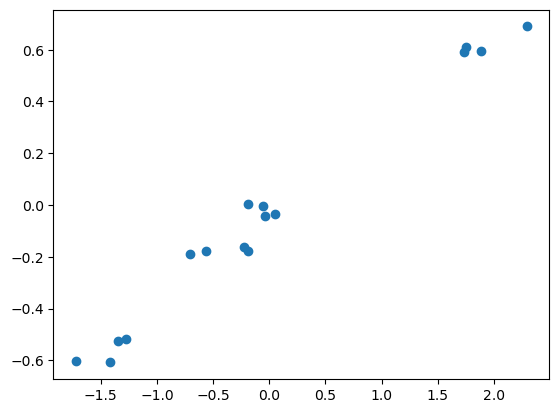

In [78]:
plt.scatter(params_sklearn_mean, params_pytorch_mean) # the two models learn similar average weights...

In [79]:
param_min = params_pytorch.min(axis=0)
param_max = params_pytorch.max(axis=0)
param_std = params_pytorch.std(axis=0)

In [80]:
for k, v in mapping.items():
    print(f'{k}: mean = {params_pytorch_mean[v]:.4f} (vs {params_sklearn_mean[v]:.4f}), std = {param_std[v]:.4f}, min = {param_min[v]:.4f}, max = {param_max[v]:.4f}')

AA: mean = -0.5245 (vs -1.3428), std = 0.3390, min = -1.0977, max = 0.9291
AC: mean = -0.1782 (vs -0.1903), std = 0.2246, min = -0.6544, max = 0.9667
AG: mean = 0.0024 (vs -0.1917), std = 0.2262, min = -0.5552, max = 1.0530
AT: mean = -0.6035 (vs -1.7206), std = 0.3521, min = -1.1228, max = 1.2198
CA: mean = -0.1895 (vs -0.7056), std = 0.2681, min = -0.7831, max = 1.0800
CC: mean = 0.5909 (vs 1.7370), std = 0.3453, min = -0.8637, max = 1.1958
CG: mean = 0.6897 (vs 2.2948), std = 0.3826, min = -0.9997, max = 1.2154
CT: mean = -0.0034 (vs -0.0579), std = 0.2285, min = -0.5465, max = 1.0137
GA: mean = -0.0357 (vs 0.0527), std = 0.1931, min = -0.4874, max = 1.1184
GC: mean = 0.6112 (vs 1.7478), std = 0.3494, min = -0.9084, max = 1.1643
GG: mean = 0.5959 (vs 1.8888), std = 0.3490, min = -1.0484, max = 1.1813
GT: mean = -0.1609 (vs -0.2220), std = 0.2360, min = -0.6359, max = 1.0428
TA: mean = -0.6078 (vs -1.4211), std = 0.3335, min = -1.1591, max = 0.9130
TC: mean = -0.0431 (vs -0.0397), st

In [81]:
X_test, y_test = dataset[i_test]

In [84]:
y_hat = model(X_test.double())

In [85]:
y_hat = y_hat.detach().numpy()

In [86]:
y_test = y_test.numpy()

In [87]:
y_test.shape == y_hat.shape

True

In [88]:
rocs_pytorch = [ roc_auc_score(y_test[:,i], y_hat[:,i]) for i in rocs_i ]

In [89]:
np.mean(rocs_pytorch) # the average classifier performance 

0.6874342214542081

In [90]:
rocs_pytorch_argsort = np.argsort(-np.array(rocs_pytorch))

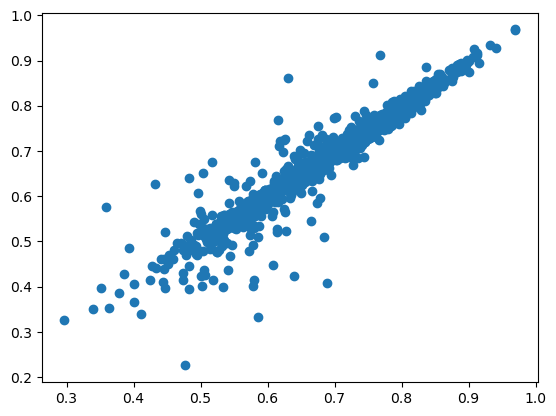

In [91]:
plt.scatter(rocs_sklearn, rocs_pytorch)

In [92]:
np.corrcoef(rocs_pytorch, rocs_sklearn)

array([[1.        , 0.96732436],
       [0.96732436, 1.        ]])

In [93]:
rocs_pytorch_argsort[0:10]

array([ 385,  257, 1413,  846,  351,   31,  658,  670,  109,  542])

In [94]:
rocs_sklearn_argsort[0:10]

array([ 385,  257,  846, 1413, 1417,   31,  658,  351,  109,  656])

In [95]:
import pandas as pd

### Loading Metadata
For every output class, I have calculated different quality metrics (`*_QC.tsv`) and extracted relevant metadata (`*_metadata_processed.tsv`).

In [96]:
md_qc = pd.read_csv('../220407_hg38_roi_mincov2_nc10_QC.tsv', sep='\t')
md = pd.read_csv('data/processed/221111_encode_metadata_processed.tsv', sep='\t')

In [97]:
md.rename(columns={c: c.replace('.','_') for c in md.columns}, inplace=True)
md_qc.rename(columns={c: c.replace('.','_') for c in md.columns}, inplace=True)
md_qc.rename(columns={'Unnamed: 0': 'File_accession'}, inplace=True)
# 221111_encode_metadata_processed.tsv contains information about the different classes
# later I would like to incorporate this metadata into the learning process
md.head()

,File_accession,Biosample_term_name,Biosample_organ_slims,Biosample_system_slims,Biosample_developmental_slims,Biosample_organism,proc_Assay_lvl1,proc_target,Experiment_date_released,Library_lab,spot2_score,five_percent_narrowpeaks_count,frip,reproducible_peaks,proc_age_bin,proc_age_bin_units,proc_Biosample_life_stage
0,ENCFF007FAW,gastroesophageal sphincter,"musculature of body,stomach","digestive system,musculature",endoderm,Homo sapiens,ATAC-seq,Accessible DNA,2016-06-15,/labs/michael-snyder/,NaN,NaN,0.220021,148398.0,50,year,adult
1,ENCFF009YES,left colon,"colon,intestine,large intestine",digestive system,endoderm,Homo sapiens,ATAC-seq,Accessible DNA,2020-08-17,/labs/michael-snyder/,NaN,NaN,0.557630,260427.0,45,year,adult
2,ENCFF010JOP,adrenal gland,"adrenal gland,endocrine gland",endocrine system,"ectoderm,mesoderm",Homo sapiens,ATAC-seq,Accessible DNA,2016-10-31,/labs/michael-snyder/,NaN,NaN,0.282873,213082.0,50,year,adult
3,ENCFF012BKZ,heart right ventricle,heart,circulatory system,mesoderm,Homo sapiens,ATAC-seq,Accessible DNA,2020-08-05,/labs/michael-snyder/,NaN,NaN,0.320655,237529.0,60,year,adult
4,ENCFF018EMP,sigmoid colon,"colon,intestine,large intestine",digestive system,endoderm,Homo sapiens,ATAC-seq,Accessible DNA,2016-06-15,/labs/michael-snyder/,NaN,NaN,0.128024,123460.0,35,year,adult


In [98]:
# 220407_hg38_roi_mincov2_nc10_QC.tsv contains quality metrics....
md_qc.head()

,File_accession,N_peaks,bp_covered,non_zero,score_max,score_mean,score_median,score_min,score_q25,score_q75,...,TSS_lncRNA_enrich,TSS_protein_coding_enrich,TSS_rRNA_enrich,promoter_lncRNA_enrich,promoter_protein_coding_enrich,promoter_rRNA_enrich,CDS_enrich,five_prime_UTR_enrich,three_prime_UTR_enrich,intron_enrich
0,ENCFF003IMJ,28868.0,12878538.0,0.006282,18.11870,5.255017,5.015800,2.041190,4.266300,5.927760,...,1.075011,0.511839,0.000000,0.933792,0.624095,0.000000,2.047153,0.992063,2.064651,0.711246
1,ENCFF003KOQ,270663.0,59051563.0,0.028561,19.67660,0.743396,0.394735,0.007519,0.236841,0.785710,...,6.383012,8.532097,2.121995,2.981906,3.052459,0.567541,1.462436,7.948689,1.058709,1.100186
2,ENCFF003KVZ,3151.0,794841.0,0.000371,14.47028,3.343118,3.331290,1.865750,3.001530,3.681715,...,2.763362,3.730073,0.000000,2.363636,2.952908,0.000000,1.277884,4.135471,1.589795,1.242434
3,ENCFF003TGC,74706.0,96037308.0,0.046598,78.86799,7.510577,4.893270,1.742160,3.920620,7.609360,...,5.411217,8.217849,1.300609,3.748547,4.321479,0.722470,2.202078,9.579459,1.321944,1.191383
4,ENCFF004ANL,69167.0,111641447.0,0.054231,95.88441,11.268159,6.088260,1.921710,4.456770,11.942465,...,4.715368,7.121110,0.558776,3.403606,3.997887,0.344880,2.081526,8.259164,1.479355,1.346014


In [99]:
md = md.merge(md_qc, on=['File_accession']).sort_values(['File_accession']).reset_index(drop=True)
del(md_qc)

In [100]:
md.shape

(2106, 286)

In [101]:
md_filter = md.loc[rocs_i]

In [102]:
md_filter

,File_accession,Biosample_term_name,Biosample_organ_slims,Biosample_system_slims,Biosample_developmental_slims,Biosample_organism,proc_Assay_lvl1,proc_target,Experiment_date_released,Library_lab,...,TSS_lncRNA_enrich,TSS_protein_coding_enrich,TSS_rRNA_enrich,promoter_lncRNA_enrich,promoter_protein_coding_enrich,promoter_rRNA_enrich,CDS_enrich,five_prime_UTR_enrich,three_prime_UTR_enrich,intron_enrich
1,ENCFF003KOQ,heart,heart,circulatory system,mesoderm,Homo sapiens,DNase-seq,Accessible DNA,2016-09-22,/labs/john-stamatoyannopoulos/,...,6.383012,8.532097,2.121995,2.981906,3.052459,0.567541,1.462436,7.948689,1.058709,1.100186
3,ENCFF003TGC,skin epidermis,"epithelium,skin of body",integumental system,ectoderm,Homo sapiens,ChIP-seq,H3K27ac,2020-09-10,/labs/bradley-bernstein/,...,5.411217,8.217849,1.300609,3.748547,4.321479,0.722470,2.202078,9.579459,1.321944,1.191383
4,ENCFF004ANL,esophagus muscularis mucosa,"esophagus,musculature of body","digestive system,musculature",mesoderm,Homo sapiens,ChIP-seq,H3K27ac,2016-11-03,/labs/bradley-bernstein/,...,4.715368,7.121110,0.558776,3.403606,3.997887,0.344880,2.081526,8.259164,1.479355,1.346014
5,ENCFF004EUA,middle frontal area 46,brain,central nervous system,ectoderm,Homo sapiens,DNase-seq,Accessible DNA,2021-01-12,/labs/john-stamatoyannopoulos/,...,11.058176,18.460334,6.308666,3.739065,4.052092,2.336251,2.711870,15.484800,1.227702,0.934454
6,ENCFF004MFA,head of caudate nucleus,brain,central nervous system,ectoderm,Homo sapiens,DNase-seq,Accessible DNA,2021-01-11,/labs/john-stamatoyannopoulos/,...,10.152384,14.724037,1.926967,3.918120,4.220762,1.506494,2.677112,13.078340,1.364239,1.076020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,ENCFF994UIF,adrenal gland,"adrenal gland,endocrine gland",endocrine system,"ectoderm,mesoderm",Homo sapiens,ATAC-seq,Accessible DNA,2020-08-05,/labs/michael-snyder/,...,5.485765,7.918637,0.000000,2.932820,3.323337,0.395157,2.166409,8.617711,1.341014,1.162616
2100,ENCFF995QIB,psoas muscle,musculature of body,musculature,mesoderm,Homo sapiens,DNase-seq,Accessible DNA,2020-09-28,/labs/john-stamatoyannopoulos/,...,10.407628,16.313753,4.504222,4.028323,4.593273,1.946026,3.302582,14.482964,1.406328,1.051833
2101,ENCFF997GTD,spleen,"immune organ,spleen","digestive system,immune system",mesoderm,Homo sapiens,ChIP-seq,H3K4me1,2013-07-31,/labs/bing-ren/,...,1.514176,1.464227,0.000000,2.126884,2.377406,0.476571,0.898317,2.176440,1.000872,1.454770
2102,ENCFF997KKX,spleen,"immune organ,spleen","digestive system,immune system",mesoderm,Homo sapiens,ChIP-seq,H3K4me1,2020-09-10,/labs/bradley-bernstein/,...,2.332470,2.981969,0.000000,2.945918,3.660246,0.670598,1.830973,4.180513,1.539286,1.503115


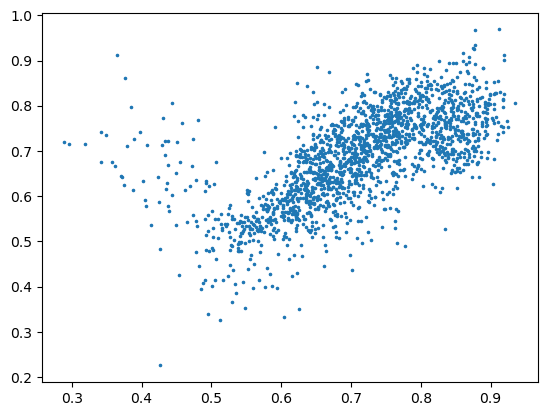

In [103]:
# GC_ROC is the performance of a classifier that only looks at the GC-content accross the full dataset

plt.scatter(md_filter.GC_ROC.values, rocs_pytorch, s=2.5)